In [ ]:
import datetime
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [ ]:
import cv2
import urllib
import requests
import PIL.Image
import numpy as np
from bs4 import BeautifulSoup

In [ ]:
# upload jpg dataset
# !unzip content.zip -d content

In [ ]:
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

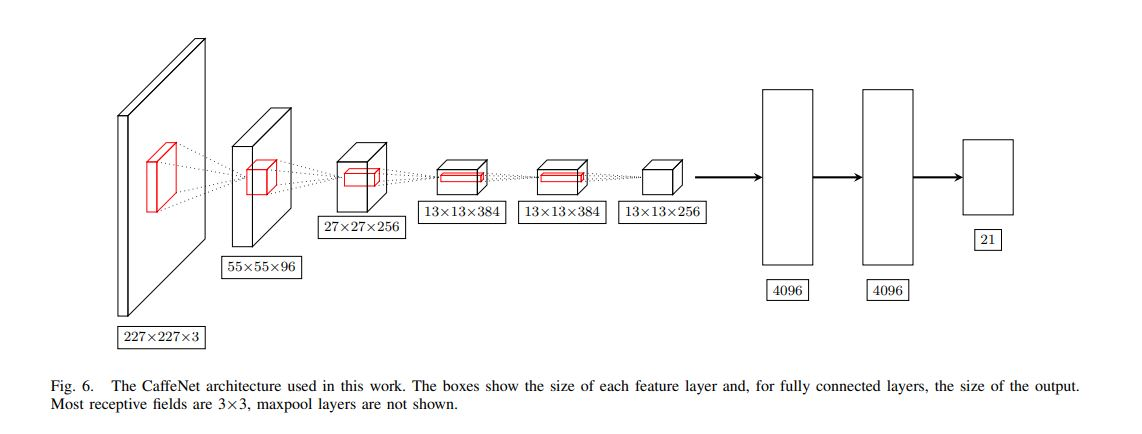

In [ ]:
# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
num_classes = 21
model = AlexNet((256, 256, 3), num_classes)

In [ ]:
# training parameters
EPOCHS = 100
BATCH_SIZE = 32
image_height = 256
image_width = 256
train_dir = "./content/train"
valid_dir = "./content/validation"
model_dir = "./my_model.h5"

In [ ]:
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

train_generator = train_datagen.flow_from_directory(train_dir,
                            target_size=(image_height, image_width),
                            color_mode="rgb",
                            batch_size=BATCH_SIZE,
                            seed=1,
                            shuffle=True,
                            class_mode="categorical")

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                            target_size=(image_height, image_width),
                            color_mode="rgb",
                            batch_size=BATCH_SIZE,
                            seed=7,
                            shuffle=True,
                            class_mode="categorical"
                            )
train_num = train_generator.samples
valid_num = valid_generator.samples

In [ ]:
model.summary()

# start training
history = model.fit(train_generator,
            epochs=EPOCHS,
            steps_per_epoch=train_num // BATCH_SIZE,
            validation_data=valid_generator,
            validation_steps=valid_num // BATCH_SIZE,
            verbose=2)


# save the whole model
model_save = './my_model.h5'
model.save(model_save)

In [ ]:
# train_loss_his
# train_acc_his 
# val_loss_his 
# val_acc_his
import matplotlib.pyplot as plt
import numpy as np
import json

plt.plot(model.history.history['loss'], 'navy', linestyle = 'dotted', label = 'train_loss')
plt.plot(model.history.history['val_loss'], 'red', linestyle = 'dotted', label = 'val_loss')
plt.legend(loc='best')
plt.show()

In [ ]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [ ]:
# 21 classes
class_names = ['agricultural', 'airplane', 'baseballdiamond', 
          'beach', 'buildings', 'chaparral',
          'denseresidential', 'forest', 'freeway',
          'golfcourse', 'harbor', 'intersection',
          'mediumresidential', 'mobilehomepark', 'overpass',
          'parkinglot', 'river', 'runway',
          'sparseresidential', 'storagetanks', 'tenniscourt'] 

x_valid, label_batch  = next(iter(valid_generator))
prediction_values = np.argmax(model.predict(x_valid), axis=-1)

# set up the figure
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the images: each image is 227x227 pixels
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(x_valid[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
    # prediction is the same as label(TRUE) -> the text is blue
    if prediction_values[i] == np.argmax(label_batch[i]):
        # label the image with the blue text
        ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
    # prediction is not the same as label(FALSE) -> the text is red
    else:
        # label the image with the red text
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)